In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import torch

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))

    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mathplotlib.colors.Colormap.cm.bone, **options)
    plt.axis("off")

images = X_train[:100]
plt.figure(figsize = (8,8))
plot_digits(images, images_per_row=10)

In [7]:
X_train.shape

(60000, 28, 28)

In [3]:
img_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
img_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

- sklearn의 OneHotEncoder을 이용해서 label을 OneHotVector의 형태로 변환하려는 시도를 계속 반복했는데 맞지 않았다.
- 알고 보니 sklearn.preprocessing의 OneHotEncoder()은 (X, Y)를, 즉 데이터 전체를 2D array의 형태로 입력해서 fit()을 진행해야 하는 것이었다.
- This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels.  


** Note: a one-hot encoding of y labels should use a LabelBinarizer instead.**

In [4]:
from sklearn.preprocessing import LabelBinarizer
LabelBin = LabelBinarizer()
Ytrain_Hot = LabelBin.fit_transform(Y_train)
Ytest_Hot = LabelBin.fit_transform(Y_test)

### 1. KNeighbors Classifier
- Neighbors-based classification is a type of instance-based learning or non-generalizing learning:  
    - it does not attempt to construct a general internal model, but simply stores instances of the training data.   
- Classification is computed from a simple majority vote of the nearest neighbors of each point:
    - a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

- scikit-learn implements two different nearest neighbors classifiers: 
1. KNeighborsClassifier   
: implements learning based on the  nearest neighbors of each query point, where  is an integer value specified by the user.   

2. RadiusNeighborsClassifier   
: implements learning based on the number of neighbors within a fixed radius  of each training point, where  is a floating-point value specified by the user.  

In [11]:
from sklearn.neighbors import KNeighborsClassifier
KNclf = KNeighborsClassifier(n_neighbors = 3, leaf_size = 20)
KNclf.fit(img_train/255, Ytrain_Hot)
KNAccuracy = KNclf.score(img_test/255, Ytest_Hot)

In [13]:
print('KNeigClf Accuracy : {}'.format(KNAccuracy * 100))

KNeigClf Accuracy : 84.52


## Random Tree

### Random Tree Classifier
```py3
class sklearn.tree.DecisionTreeClassifier(
    *, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
    max_features=None, random_state=None, max_leaf_nodes=None, 
    min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0
)
```

#### Parameters 
- parameter의 값은 Regressor과 같은 정보를 사용해 주면 된다.
- 대표적으로 criterion, splitter, max_depth, max_features, max_leaf_nodes의 parameter을 많이 설정한다.  

1. criterion     
    : 현재 기준 노드의 feature의 적정성을 계산해주는 방법을 설정하는 parameter이다.  
    - 기본적으로 지니 계수가 'gini'의 이름으로 설정이 되어있지만, 만약에 entropy loss로 측정하고 싶다면 'entropy'로 바꾸어주면 된다.  

2. splitter  
    : 각 기준 노드에 의해서 region split을 진행하는데 여러개의 기준 후보들 중에서 어떤 split을 선택해 줄지 결정할 수 있도록 하는 parameter이다.  
    - 기본적으로는 'best'가 설정이 되어서 더 성능이 좋은 split을 선택하지만 'random'으로 바꾸어서 둘중 아무 split이나 선택하기도 한다.  

3. max_depth   
    : 무제한적으로 깊이가 깊어지면 (일반적으로 제한을 가하지 않으면 모든 노드가 leaf node가 될 때 까지 분류를 멈추지 않는다.)  
    띠라서 이 patameter을 설정해 주면 적당한 선에서 멈추게 된다.  

4. max_features  
    : 여기서 말하는 feature이란 split을 결정해 주는 기준이고, max_features라는 parameter은 제일 적당한 region split을 정하기 위해서 고려해 주는 feature의 개수의 최대값이다.
    - int : then consider max_features features at each split.
    - float : then max_features is a fraction and int(max_features * n_features) features are considered at each split.
    - “auto” : then max_features=sqrt(n_features).
    - “sqrt” : then max_features=sqrt(n_features).
    - “log2” : then max_features=log2(n_features).
    - None : then max_features=n_features.  

5. max_leaf_nodes
    : 최대 leaf_node의 개수를 설정해준다.
    - 만약 아무 숫자도 설정해 주지 않으면 모두 leaf_node, 즉 더이상 나눌 필요가 없는 P = 1인 노드일 때 까지 분류 작업을 멈추지 않는다.


- MNIST fashion img를 X데이터로서 입력을 한 것이기 때문에 784개의 픽셀값 각각을 feature로 인식해서 10개의 class로 분류를 했을 것이다.

In [24]:
from sklearn.tree import DecisionTreeClassifier

TreeCLF = DecisionTreeClassifier(max_depth = 30, max_features = "log2", max_leaf_nodes = 1000, random_state = 42)
TreeCLF.fit(img_train/255, Ytrain_Hot)
TreeAccuracy = TreeCLF.score(img_test/255, Ytest_Hot)

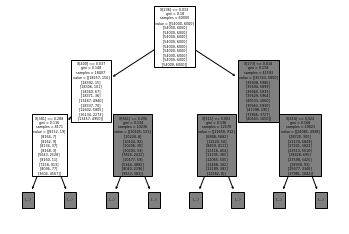

In [31]:
from sklearn import tree
tree.plot_tree(TreeCLF, max_depth = 2)
plt.show()

In [25]:
print('TreeAccuracy : {}'.format(TreeAccuracy * 100))

TreeAccuracy : 74.91


## Ensemble
### 1. Voting Classifier
```py3
class sklearn.ensemble.VotingClassifier(
    estimators, *, voting='hard', weights=None, 
    n_jobs=None, flatten_transform=True, verbose=False
)
```
#### Parameters  
1. voting   
    : Voting Method에서는 Hard Voting과 Soft Voting이라는 두 가지 방법이 존재하는데, 이 방법들을 결정해 주는 parameter이다.
    1. ‘hard’ : uses predicted class labels for majority rule voting.    
    2. ‘soft’ : predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.  
    
2. weights  
    : Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities before averaging (soft voting).
    - Uses uniform weights if None.

3. estimators  
    : 이 parameter은 필수로 입력해 주어야 하는 것으로, voting classifier의 분류/회귀 방법이 다양한 알고리즘을 이용하는 머신 러닝 모델의 집단 지성을 이용하는 방법인 만큼 직접 지정해 주어야 한다.

In [4]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

clf1 = LogisticRegression(random_state = 42, solver = 'sag')
clf2 = GaussianNB()
clf3 = RandomForestClassifier(n_estimators = 50, random_state = 42)

VoteCLF = VotingClassifier(
    estimators = [
        ('LogReg', clf1), ('Gauss', clf2), ('Forest', clf3)
    ], voting = 'hard'
)

VoteCLF.fit(img_train/255, Y_train)
VoteAccuracy = VoteCLF.score(img_test/255, Y_test)
print('Voting Clf Accuracy : {}'.format(VoteAccuracy*100))


C:\CONDA\envs\final\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Voting Clf Accuracy : 85.59


In [5]:
VoteCLF.estimators

[('LogReg', LogisticRegression(random_state=42, solver='sag')),
 ('Gauss', GaussianNB()),
 ('Forest', RandomForestClassifier(n_estimators=50, random_state=42))]

### 2. Random Forest Classifier
: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
    - 다수의 decision tree classifier을 이용해 데이터셋을 여러개로 나눈 뒤에 각각의 decision tree classifier의 예측에 대한 평균값을 이용해서 decision tree의 제일 큰 단점인 ovefitting을 보완하는 방법이다.
```py3
class sklearn.ensemble.RandomForestClassifier(
    n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
    verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None
)
```
#### Parameters  
1. bootstrap (boolean 값을 갖는다)

    : Whether bootstrap samples are used when building trees  
        - if False, the whole dataset is used to build each tree.  

2. class_weight  

    : Weights associated with classes in the form {class_label: weight}  
    - If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y   

        1. “balanced”   
            : uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

        2. “balanced_subsample”  
            : is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

    - For multi-output, the weights of each column of y will be multiplied.


In [9]:
from sklearn.ensemble import RandomForestClassifier
RandForCLF = RandomForestClassifier(class_weight = "balanced_subsample", bootstrap = True, random_state = 42, max_leaf_nodes = 1000)
RandForCLF.fit(img_train, Ytrain_Hot)
RFAccuracy = RandForCLF.score(img_test, Ytest_Hot)
print('Random Forest Accuracy : {}'.format(RFAccuracy*100))

Random Forest Accuracy : 80.03


- Random Forest에서는 특정 중요도를 나타내는 속성인 'feature_importance_'를 구할 수 있다.
- 해당 분류기에 입력한 데이터는 이미지 데이터로, 28 x 28의 픽셀로 구성이 되어 있다.
- 이를 1D크기의 array로 바꾸어서 입력하기 때문에 결과적으로 feature들은 각각의 픽셀인 784개인 것이다.
    - 이 각각에 대한 특성의 중요도를 그래프로 나타내 보자 (heatmap사용)

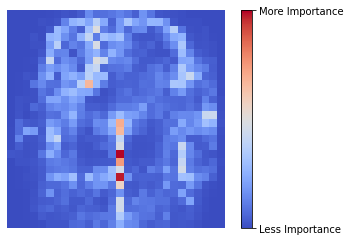

In [46]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Colormap as cm
def plot_digit(data):
    image = data.reshape(28, 28) # 이미지를 하나씩 한수에 입력해서 출력해 본다.
    # 1D array로, img_data의 shape가 (data number, 784)이기 떄문에 이를 reshape해야 이미지로 인식이 된다.
    plt.imshow(image, cmap = matplotlib.cm.coolwarm, interpolation = "nearest")
    plt.axis("off")

plot_digit(RandForCLF.feature_importances_)

cbar = plt.colorbar(ticks = [RandForCLF.feature_importances_.min(), RandForCLF.feature_importances_.max()])
cbar.ax.set_yticklabels(['Less Importance', "More Importance"])
plt.show()

### 3. Gradient Boosting Machine (GBM)   

: Boosting Method를 사용해서 예측을 수행하는 것이다.   
- Boosting이라는 방법은 앞선 다른 기법들인 Voting과 Bagging과 달리 learning_rate라는 파라미터를 필요로 한다. 
- 이는 경사 하강법과 손실함수 f(x)를 이용해서 오차 계산시에 Loss = f(y - y_predict)라고 한다면 이를 최소화 하는 방향으로 value들을 갱신한다.
- AdaBoost method와 마찬가지로 GradientBoosting은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다.
- 그러나 AdaBoost처럼 반복마다 sample의 가중치를 수정하는 대신에 이전 예측기가 만든 **잔여 오차(residual loss)**에 새로운 예측기를 학습 시킨다.


#### 경사 하강법과 학습률
- 학습률이 너무 낮으면 앙상블을 훈련 세트에 학습시키기 위해서 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아지게 된다. 그러나 트리가 너무 많으면 overfitting이 발생할 위험이, 학습률이 너무 높으면 트리의 수가 너무 적어져서 예측도가 낮아진다.   

    - 그 이유는 학습률이 높을 수록 손실 함수에서의 최저점을 찾기 위해 움직이는 정도가 너무 커져서 최저점에 도달을 못할 수도 있기 때문이다.  
    - 그리고 overfitting은 일반적으로 train set에만 과대 적합이 되고 실제 우리가 사용해야 하는 데이터에는 정작 적합하지 않을 수 있기 때문에 문제가 되는 것이다.


```py3
sklearn.ensemble.GradientBoostingClassifier(
    *, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse',
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
    min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None,
    max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1,
    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
```

#### Parameters
1. loss
: The loss function to be optimized.   

    - ‘deviance’    
    : refers to deviance (= logistic regression) for classification with probabilistic outputs.   

    - ‘exponential’   
    : gradient boosting recovers the AdaBoost algorithm.

2. subsample
: The fraction of samples to be used for fitting the individual base learners.   
-> 각 트리가 훈련을 할 때에 사용할 훈련 샘플의 비율을 지정할 수 있도록 하는 매개 변수이다.

    - If smaller than 1.0 this results in Stochastic Gradient Boosting.   
    - subsample interacts with the parameter n_estimators.   
    - Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias  
      = 편향이 높아지는 대신에 분산이 낮아지게 되는 것이다. 이것을 확률적 그래디언트 부스팅이라고 한다.

3. criterion
: 결정 트리에서 해당 region에서의 split의 정확도/적합도를 평가할 수 있도록 도와주는 기준

    - ‘friedman_mse’   
    : mean squared error with improvement score by Friedman 

    - ‘mse’   
    : mean squared error  

    - ‘mae’  
    : mean absolute error  
    
- The default value of ‘friedman_mse’ is generally the best as it can provide a better approximation in some cases.

#### Early Stopping에 관여하는 Hyperparameter

1. n_iter_no_change  
- used to decide if early stopping will be used to terminate training when validation score is not improving.  
    - By default it is set to None to disable early stopping.    
    - If set to a number, it will set aside validation_fraction size of the training data as validation and terminate training when validation score is not improving in all of the previous n_iter_no_change numbers of iterations.   
    - The split is stratified.    

2. n_estimators  
- The number of boosting stages to perform.  
    - Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.   

3. validation_fraction
- 현재 학습중인 데이터 셋에서 손실이 더이상 줄어들지 않음에도 학습을 진행하는 상황을 막기 위해서 따로 학습 중에 검증 데이터로 사용할 비율
    - 0에서 1 사이의 float값으로 설정해 주면 된다.



In [6]:
from sklearn.ensemble import GradientBoostingClassifier

GradBoostCLF = GradientBoostingClassifier(max_depth = 2, n_estimators = 20, learning_rate = 0.1, random_state=42, 
                                            validation_fraction = 0.2, n_iter_no_change = 10, verbose = 1)
GradBoostCLF.fit(img_train, Y_train)
GradBoostAcc = GradBoostCLF.score(img_test, Y_test)

print('Gradient Boosting Accuracy : {}'.format(GradBoostAcc * 100))



      Iter       Train Loss   Remaining Time 
         1           1.9332           31.63m
         2           1.7213           28.33m
         3           1.5641           25.76m
         4           1.4393           23.92m
         5           1.3337           22.25m
         6           1.2478           20.76m
         7           1.1723           19.05m
         8           1.1080           17.44m
         9           1.0493           15.79m
        10           1.0010           14.23m
        20           0.7028            0.00s
Gradient Boosting Accuracy : 78.94


- 위의 결과를 이용해서 staged_predict() 함수를 사용하게 되면 최적의 estimator의 개수를 구해줄 수가 있다.
- 즉, 10개의 decision tree에 대해서 예측을 하는데 이때에 가장 error이 작은 값을 구해주고 해당 estimator만큼만 (random_state를 지정해서 일정한 값이 계속 나올 수 있도록 설정을 해준 뒤에) Early Stopping(조기 종료)를 시행해 줄 수 있다.
    - 원래는 n_estimators의 기본 설정값이 100이고, 사실 이 수는 많을 수록 예측의 정확도가 올라가겠지만 시간이 너무 오래 걸린다는 단점이 존재한다.

In [8]:
from sklearn.metrics import mean_squared_error

errors = [mean_squared_error(Y_test, y_pred)
          for y_pred in GradBoostCLF.staged_predict(img_test)]
best_n_estimators = np.argmin(errors) + 1

GradBoost_best = GradientBoostingClassifier(max_depth = 2, n_estimators = best_n_estimators, learning_rate = 0.1, random_state=None, 
                                            validation_fraction = 0.2, n_iter_no_change = 10, verbose = 1)
GradBoost_best.fit(img_train, Y_train)
BestGradAcc = GradBoost_best.score(img_test, Y_test)

print('Best Gradient Boosting Accuracy : {}'.format(BestGradAcc * 100))

      Iter       Train Loss   Remaining Time 
         1           1.9333           36.70m
         2           1.7221           33.15m
         3           1.5654           28.78m
         4           1.4412           27.02m
         5           1.3340           25.39m
         6           1.2479           23.86m
         7           1.1716           21.84m
         8           1.1071           19.80m
         9           1.0517           18.02m
        10           0.9996           16.25m
        20           0.7041            0.00s
Best Gradient Boosting Accuracy : 79.02
